In [6]:
# for standard XGBoost implementation
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from datetime import datetime
from random import randint

# for XGBoost custom wrapper
import sys
import math
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import KFold

# other
from scipy.stats import randint, uniform

%matplotlib inline

# XGB Boost Builder & Grid Search

In [4]:
# get X, Y, and column headers / names for random forest
def get_lstm_matrix(df, target_col, periods_ahead, drop_target = False, rate_of_change = False):
    
    # read in all cols with closing prices
    df = df[df[target_col].notnull()]
    
    # clean data for BTC_ETH starts on 2015-08-09
    df = df[df.index >= datetime(2015, 8, 9)]
    
    # select target column and create it in dataset
    target_col_name = target_col + '_target'
    df[target_col_name] = df[target_col].shift(-periods_ahead)
    
    # if looking at the rate of change instead of actual values
    if rate_of_change:
        df[target_col_name] = (df[target_col_name] - df[target_col]) / df[target_col]
    
    # drop the original target col
    if drop_target:
        df = df.drop(target_col, 1)
    
    # drop null values
    df.dropna(inplace = True)
    
    # convert to matrix
    dat = df.as_matrix()
    
    # convert to float (just in case)
    dat = dat.astype('float32')
    
    # get dates for QA
    dates = df.index.tolist()
    
    return df, dat, dates

# helper to get ranked features using random forrest regression
def get_ranked_features(X, Y, col_names, nb_epochs):
    
    scores = {}
    
    for i in range(nb_epochs):
        
        # create / fit new random forest model
        rf = RandomForestRegressor()
        rf.fit(X, Y)
        
        # loop through each col and add up the scores
        for score, col in zip(map(lambda x: x, rf.feature_importances_), col_names):

            if i == 0:
                scores[col] = score
            else:
                scores[col] += score
    
    # sort the scores in descending order
    sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_scores

# helper to convert the grid search results into a df
def get_grid_search_df(mod, hyperparams, sortby = 'mean', rmse = False, parse_mean = True):
    
    # set list for easy df building
    grid_search_results = []
    
    # loop through the score tuple
    for result in mod.grid_scores_:
        
        gsr = {}
        
        # add each of the hyperparamaters to the current dict
        for p in hyperparams:
            gsr[p] = result[0][p]
        
        # and then add the mean and std
        if not rmse:
            gsr['mean'] = result[1]
        elif rmse:
            gsr['mean'] = abs(result[1]) ** 0.5
        gsr['std'] = result[2].std()

        grid_search_results.append(gsr)
    
    # convert to df, sorting by error metric (or whatever)
    df = pd.DataFrame(grid_search_results).sort_values(sortby, ascending = False).reset_index(drop = True)
    
    # and parse out the values from the element tuples
    if parse_mean:
        df['mean'] = df['mean'].apply(lambda x: x[0])
    
    return df

# classifies the target for multi-class classification
def classify_target(tar, n_class, step):
    
    # check if there are an even amount of classes, kick back an error otherwise
    if n_class % 2 != 0:
        print('Number of classes needs to be even.')
        return None
    
    # since the classes are straddling 0, there will be the same
    # amount for each sign
    n_class_per_sign = int(n_class / 2)
    
    # loop through each one of the classes, and if it found to less than a certain
    # class, classify it as such. finally, multiply it by the target's sign.
    for i in range(1, n_class_per_sign):        
        if abs(tar) < (step * i):
            return i * np.sign(tar)
    
    # if it doesn't fit in any of the "inner" classes, then classify it as an
    # "outter" class.
    try:
        return int((i + 1) * np.sign(tar))
    except:
        return int(1 * np.sign(tar))

# LOAD DATA

In [219]:
# read in training data
df = pd.read_csv('train_recent.csv')

# clean import
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)

In [220]:
# pre-process data
adf, dat, dates = get_lstm_matrix(df,
                                  target_col = 'polo_btceth_close',
                                  periods_ahead = 4,
                                  drop_target = True,
                                  rate_of_change = True
                                 )

# add the target col
adf['direction'] = adf.polo_btceth_close_target.apply(lambda x: np.sign(x))

# set X and y
X = adf.ix[:,:-2].as_matrix()
y = adf.ix[:,-1].as_matrix()

In [ ]:
# get test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# check shape
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# STANDARD XGB IMPLEMENTATION

## With Custom Hyperparams

In [16]:
# set hyperparams
params = {'colsample_bytree': 0.9,
          'eta': 0.05,
          'max_depth': 6,
          #'num_boost_round': 100,
          'subsample': 1.0
         }

# create a Data Matrix
xgdmat = DMatrix(X_train, y_train)

# train the model with said matrix
final_gb = xgb.train(params, xgdmat, num_boost_round = 100)

testdmat = DMatrix(X_test)

#accuracy_score(y_test, final_gb.predict(testdmat))

#final_gb.predict(testdmat)

## Default Hyperparamaters

In [9]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train,
          y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('accuracy:', accuracy)

accuracy: 0.75625


## Several Iterations

In [322]:
# optimal "slow" learner
params_1 = {
    
    'objective': 'binary:logistic',
    'max_depth': 6,
    'n_estimators': 1215,
    'learning_rate': 0.003,
    'min_child_weight': 0.05,
    'subsample': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'gamma': 0
}

# optimal "fast" learner
params_2 = {
    
    'objective': 'binary:logistic',
    'max_depth': 6,
    'n_estimators': 900,
    'learning_rate': 0.15,
    'min_child_weight': 0.1,
    'subsample': 0.85,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'gamma': 0
}

In [328]:
accs = []
accs_list = []

for j in range(5):
    print(j)
    for i in range(25):
        print(i)
        # get test and training set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

        # fit model no training data
        model = XGBClassifier(**params_1)
        model.fit(X_train, y_train)

        # make predictions for test data
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]

        # evaluate predictions
        accuracy = accuracy_score(y_test, predictions)

        accs.append(accuracy)
    
    accs_list.append(list(accs))

    
hist_series_slow = pd.Series(accs)
box_df_slow = pd.DataFrame(accs_list).T

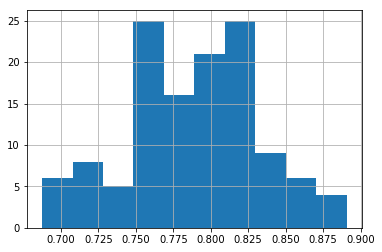

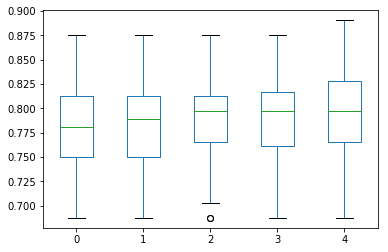

In [1]:
accs = []
accs_list = []

for j in range(5):
    print(j)
    for i in range(25):
        print(i)
        # get test and training set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

        # fit model no training data
        model = XGBClassifier(**params_2)
        model.fit(X_train, y_train)

        # make predictions for test data
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]

        # evaluate predictions
        accuracy = accuracy_score(y_test, predictions)

        accs.append(accuracy)
    
    accs_list.append(list(accs))

    
hist_series_fast = pd.Series(accs)
box_df_fast = pd.DataFrame(accs_list).T

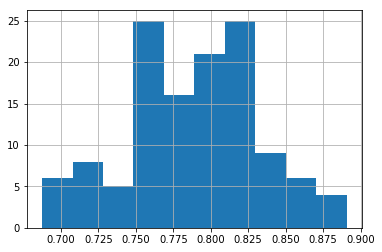

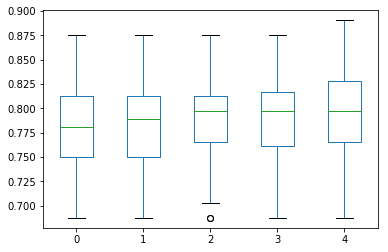

In [331]:
hist_series_slow.hist(bins = 10);
print()
box_df_slow.plot(kind = 'box');

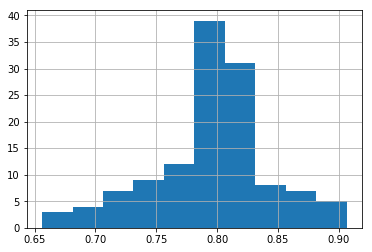

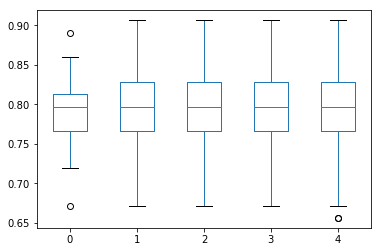

In [332]:
hist_series_fast.hist(bins = 10);
print()
box_df_fast.plot(kind = 'box');

In [335]:
hist_series_fast.describe()

count    125.000000
mean       0.792875
std        0.048805
min        0.656250
25%        0.765625
50%        0.796875
75%        0.828125
max        0.906250
dtype: float64

In [336]:
hist_series_slow.describe()

count    125.000000
mean       0.789000
std        0.044444
min        0.687500
25%        0.765625
50%        0.796875
75%        0.828125
max        0.890625
dtype: float64

# GRIDSEARCH

## Round 1 - Init

In [47]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5],
    
    # secondary
    #'min_child_weight': [0.1, 0.25, 0.5, 1, 2, 4],
    #'subsample': [0, 0.25, 0.5, 0.75, 1],
    #'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    #'reg_lambda': [0, 0.25, 0.5, 0.75, 1]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 360 



In [49]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200, 300, 400, 500], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Round 1 - Results

In [127]:
hp_list = ['learning_rate', 'max_depth', 'n_estimators']

df1 = get_grid_search_df(bst_grid, hp_list)

In [146]:
df1.head(25)

,learning_rate,max_depth,mean,n_estimators,std
0,0.25,6,0.799687,200,0.072401
1,0.25,6,0.798122,500,0.069071
2,0.50,2,0.798122,500,0.051905
3,0.10,6,0.798122,400,0.060618
4,0.10,4,0.796557,500,0.056966
5,0.25,6,0.796557,400,0.063241
6,0.25,6,0.796557,300,0.058979
7,0.50,2,0.796557,400,0.053446
8,0.50,8,0.794992,300,0.056733
9,0.10,6,0.794992,500,0.056943


               max_depth      mean  n_estimators       std
learning_rate                                             
0.0001               6.0  0.625509    258.333333  0.081835
0.0010               6.0  0.649974    258.333333  0.066202
0.0100               6.0  0.719614    258.333333  0.064644
0.1000               6.0  0.771205    258.333333  0.060886
0.2500               6.0  0.777413    258.333333  0.062090
0.5000               6.0  0.780386    258.333333  0.058459
0.7500               6.0  0.772457    258.333333  0.062723
1.0000               6.0  0.764528    258.333333  0.054402
2.0000               6.0  0.675013    258.333333  0.071602
3.0000               6.0  0.518623    258.333333  0.036543
4.0000               6.0  0.513615    258.333333  0.042771
5.0000               6.0  0.503912    258.333333  0.045881


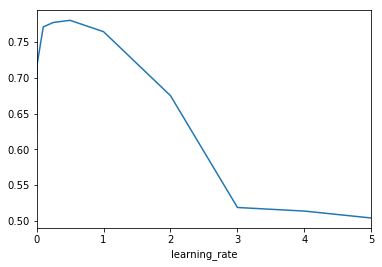

In [133]:
print(df1.groupby('learning_rate').mean())
df1.groupby('learning_rate').mean()['mean'].plot();

           learning_rate      mean  n_estimators       std
max_depth                                                 
2               1.384258  0.644475    258.333333  0.055891
4               1.384258  0.672774    258.333333  0.061731
6               1.384258  0.682425    258.333333  0.062918
8               1.384258  0.680121    258.333333  0.058344
10              1.384258  0.683642    258.333333  0.056132


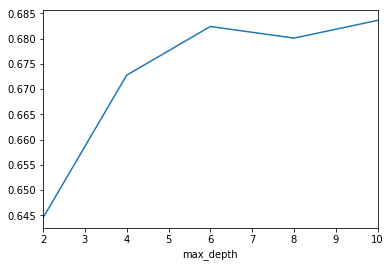

In [134]:
print(df1.groupby('max_depth').mean())
df1.groupby('max_depth').mean()['mean'].plot();

              learning_rate  max_depth      mean       std
n_estimators                                              
50                 1.384258          6  0.660224  0.060538
100                1.384258          6  0.666823  0.060347
200                1.384258          6  0.673370  0.059725
300                1.384258          6  0.676917  0.058428
400                1.384258          6  0.678482  0.057384
500                1.384258          6  0.680308  0.057597


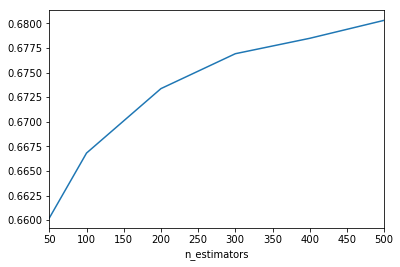

In [135]:
print(df1.groupby('n_estimators').mean())
df1.groupby('n_estimators').mean()['mean'].plot();

## Round 2 - Init

In [143]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [250, 500, 750, 1000, 1250, 1500],
    'learning_rate': [0.01, 0.1, 0.25, 0.5],
    
    # secondary
    #'min_child_weight': [0.1, 0.25, 0.5, 1, 2, 4],
    #'subsample': [0, 0.25, 0.5, 0.75, 1],
    #'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    #'reg_lambda': [0, 0.25, 0.5, 0.75, 1]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 96 



In [144]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [250, 500, 750, 1000, 1250, 1500], 'max_depth': [5, 10, 15, 20], 'learning_rate': [0.01, 0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Round 2 - Results

In [147]:
hp_list = ['learning_rate', 'max_depth', 'n_estimators']

df2 = get_grid_search_df(bst_grid, hp_list)

In [154]:
df2.head(25)

,learning_rate,max_depth,mean,n_estimators,std
0,0.25,5,0.810642,750,0.038167
1,0.25,5,0.809077,500,0.039902
2,0.25,5,0.804382,250,0.044267
3,0.25,5,0.801252,1000,0.034966
4,0.25,5,0.796557,1250,0.037083
5,0.25,5,0.796557,1500,0.038193
6,0.25,20,0.794992,500,0.042753
7,0.25,15,0.788732,500,0.042000
8,0.10,5,0.788732,1250,0.048096
9,0.25,20,0.788732,750,0.041442


               max_depth      mean  n_estimators       std
learning_rate                                             
0.01                12.5  0.768584         875.0  0.050634
0.10                12.5  0.776800         875.0  0.042443
0.25                12.5  0.785994         875.0  0.038586
0.50                12.5  0.769431         875.0  0.037084


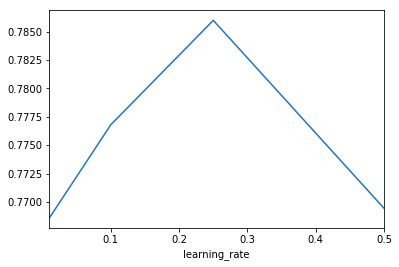

In [152]:
print(df2.groupby('learning_rate').mean())
df2.groupby('learning_rate').mean()['mean'].plot();

           learning_rate      mean  n_estimators       std
max_depth                                                 
5                  0.215  0.782407           875  0.047007
10                 0.215  0.773279           875  0.041077
15                 0.215  0.772822           875  0.039838
20                 0.215  0.772300           875  0.040826


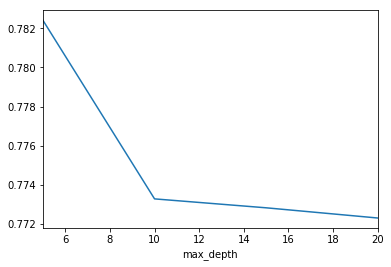

In [151]:
print(df2.groupby('max_depth').mean())
df2.groupby('max_depth').mean()['mean'].plot();

              learning_rate  max_depth      mean       std
n_estimators                                              
250                   0.215       12.5  0.771811  0.044629
500                   0.215       12.5  0.773865  0.044726
750                   0.215       12.5  0.776897  0.042969
1000                  0.215       12.5  0.776506  0.040579
1250                  0.215       12.5  0.776604  0.040159
1500                  0.215       12.5  0.775528  0.040060


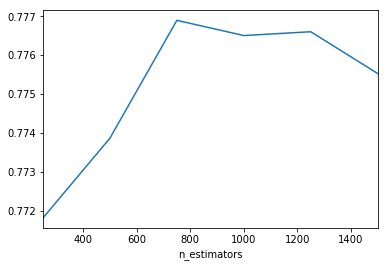

In [153]:
print(df2.groupby('n_estimators').mean())
df2.groupby('n_estimators').mean()['mean'].plot();

## Round 3 - Init

In [162]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [4, 5, 6, 7],
    'n_estimators': [500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.25],
    
    # secondary
    'min_child_weight': [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'subsample': [0, 0.25, 0.5, 0.75, 1],
    #'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    #'reg_lambda': [0, 0.25, 0.5, 0.75, 1]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 312 



In [163]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 600, 700, 800, 900, 1000], 'min_child_weight': [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [4, 5, 6, 7], 'learning_rate': [0.25]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Round 3 - Results

In [164]:
hp_list = ['learning_rate', 'max_depth', 'n_estimators', 'min_child_weight']

df3 = get_grid_search_df(bst_grid, hp_list)

In [165]:
df3.head(25)

,learning_rate,max_depth,mean,min_child_weight,n_estimators,std
0,0.25,6,0.818466,9.00,1000,0.044172
1,0.25,6,0.815336,0.25,800,0.050245
2,0.25,6,0.813772,0.25,900,0.053375
3,0.25,6,0.813772,9.00,900,0.040860
4,0.25,6,0.810642,0.25,500,0.041399
5,0.25,6,0.810642,0.25,600,0.046177
6,0.25,6,0.810642,0.25,700,0.049404
7,0.25,6,0.810642,9.00,800,0.040232
8,0.25,6,0.810642,0.25,1000,0.051923
9,0.25,6,0.810642,9.00,700,0.039121


           learning_rate      mean  min_child_weight  n_estimators       std
max_depth                                                                   
4                   0.25  0.792003          4.346154           750  0.054647
5                   0.25  0.792264          4.346154           750  0.054712
6                   0.25  0.796256          4.346154           750  0.052830
7                   0.25  0.794210          4.346154           750  0.054662


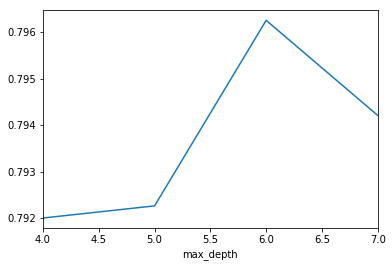

In [167]:
print(df3.groupby('max_depth').mean())
df3.groupby('max_depth').mean()['mean'].plot();

              learning_rate  max_depth      mean  min_child_weight       std
n_estimators                                                                
500                    0.25        5.5  0.793126          4.346154  0.054647
600                    0.25        5.5  0.793156          4.346154  0.054154
700                    0.25        5.5  0.793487          4.346154  0.054209
800                    0.25        5.5  0.793879          4.346154  0.054176
900                    0.25        5.5  0.793638          4.346154  0.054127
1000                   0.25        5.5  0.794812          4.346154  0.053963


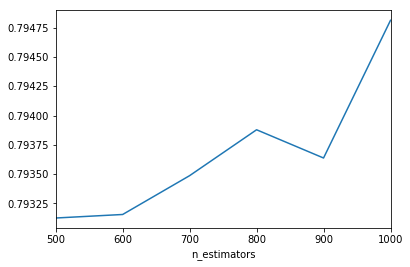

In [169]:
print(df3.groupby('n_estimators').mean())
df3.groupby('n_estimators').mean()['mean'].plot();

                  learning_rate  max_depth      mean  n_estimators       std
min_child_weight                                                            
0.25                       0.25        5.5  0.799752         750.0  0.054849
0.50                       0.25        5.5  0.790689         750.0  0.050051
0.75                       0.25        5.5  0.799426         750.0  0.054947
1.00                       0.25        5.5  0.798383         750.0  0.054123
2.00                       0.25        5.5  0.791275         750.0  0.056921
3.00                       0.25        5.5  0.794666         750.0  0.051068
4.00                       0.25        5.5  0.793884         750.0  0.049823
5.00                       0.25        5.5  0.793949         750.0  0.059294
6.00                       0.25        5.5  0.788080         750.0  0.059232
7.00                       0.25        5.5  0.792188         750.0  0.056165
8.00                       0.25        5.5  0.790102         750.0  0.052231

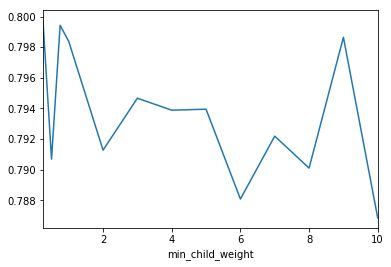

In [171]:
print(df3.groupby('min_child_weight').mean())
df3.groupby('min_child_weight').mean()['mean'].plot();

## Round 4 - Init

In [188]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [1000],
    'learning_rate': [0.25],
    
    # secondary
    'min_child_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
    'subsample': [0, 0.25, 0.5, 0.75, 1],
    'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
    'reg_lambda': [0, 0.25, 0.5, 0.75, 1]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 1625 



In [189]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000], 'reg_lambda': [0, 0.25, 0.5, 0.75, 1], 'min_child_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3], 'learning_rate': [0.25], 'reg_alpha': [0, 0.25, 0.5, 0.75, 1], 'subsample': [0, 0.25, 0.5, 0.75, 1], 'max_depth': [6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Round 4 - Results

In [194]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda'
          ]

df4 = get_grid_search_df(bst_grid, hp_list)

In [191]:
df4.head(25)

,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0.25,6,0.813772,0.9,1000,0.50,0.00,0.056778,1.00
1,0.25,6,0.810642,0.5,1000,0.25,0.75,0.061058,1.00
2,0.25,6,0.809077,0.1,1000,0.00,0.50,0.063211,1.00
3,0.25,6,0.807512,0.2,1000,0.50,0.25,0.063770,1.00
4,0.25,6,0.807512,0.2,1000,0.00,0.25,0.065993,1.00
5,0.25,6,0.807512,1.0,1000,0.75,0.00,0.060400,1.00
6,0.25,6,0.805947,0.3,1000,0.25,0.50,0.047287,0.75
7,0.25,6,0.805947,1.2,1000,0.50,0.75,0.053881,0.75
8,0.25,6,0.804382,0.6,1000,0.00,0.75,0.066765,1.00
9,0.25,6,0.804382,0.4,1000,0.25,0.00,0.052838,0.75


                      mean
min_child_weight          
0.1               0.721189
0.2               0.720977
0.3               0.721728
0.4               0.719737
0.5               0.719299
0.6               0.717446
0.7               0.718635
0.8               0.717333
0.9               0.715606
1.0               0.716795
1.1               0.714579
1.2               0.715718
1.3               0.713189


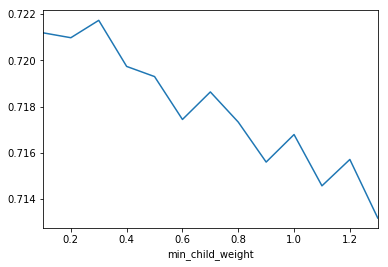

In [199]:
print(df4.groupby('min_child_weight').mean()[['mean']])
df4.groupby('min_child_weight').mean()['mean'].plot();

               mean
reg_alpha          
0.00       0.717019
0.25       0.717737
0.50       0.718507
0.75       0.718137
1.00       0.717920


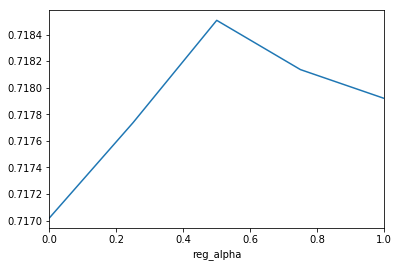

In [200]:
print(df4.groupby('reg_alpha').mean()[['mean']])
df4.groupby('reg_alpha').mean()['mean'].plot();

                mean
reg_lambda          
0.00        0.714207
0.25        0.716769
0.50        0.718849
0.75        0.719432
1.00        0.720063


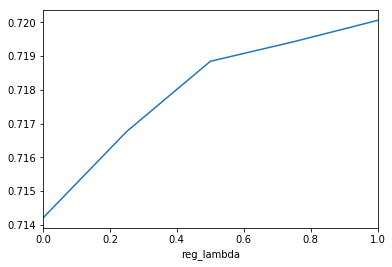

In [201]:
print(df4.groupby('reg_lambda').mean()[['mean']])
df4.groupby('reg_lambda').mean()['mean'].plot();

               mean
subsample          
0.00       0.480438
0.25       0.758907
0.50       0.775977
0.75       0.786007
1.00       0.787991


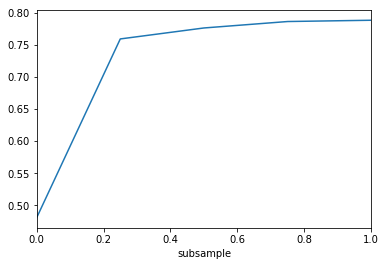

In [202]:
print(df4.groupby('subsample').mean()[['mean']])
df4.groupby('subsample').mean()['mean'].plot();

## Round 5 - Init

In [9]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [900, 950, 1000, 1050, 1100],
    'learning_rate': [0.25],
    
    # secondary
    'min_child_weight': [0, 0.1, 0.2, 0.3],
    'subsample': [0.9, 1],
    'reg_alpha': [0.5],
    'reg_lambda': [0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 480 



In [10]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_lambda': [0.9, 1], 'learning_rate': [0.25], 'max_depth': [6], 'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 'reg_alpha': [0.5], 'min_child_weight': [0, 0.1, 0.2, 0.3], 'subsample': [0.9, 1], 'n_estimators': [900, 950, 1000, 1050, 1100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

## Round 5 - Results

In [11]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df5 = get_grid_search_df(bst_grid, hp_list)

In [12]:
df5.head(25)

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0.0,0.25,6,0.809077,0.3,900,0.5,1.0,0.056055,1.0
1,0.0,0.25,6,0.809077,0.3,1050,0.5,1.0,0.056055,1.0
2,0.0,0.25,6,0.809077,0.3,1000,0.5,1.0,0.056055,1.0
3,0.0,0.25,6,0.809077,0.3,1100,0.5,1.0,0.056055,1.0
4,0.0,0.25,6,0.809077,0.0,1000,0.5,1.0,0.065570,0.9
5,0.0,0.25,6,0.809077,0.3,950,0.5,1.0,0.056055,1.0
6,0.0,0.25,6,0.807512,0.0,1100,0.5,1.0,0.066115,0.9
7,0.0,0.25,6,0.807512,0.0,900,0.5,1.0,0.066115,0.9
8,0.0,0.25,6,0.807512,0.0,950,0.5,1.0,0.066115,0.9
9,0.0,0.25,6,0.807512,0.0,1050,0.5,1.0,0.066115,0.9


                  mean
n_estimators          
900           0.789042
950           0.789124
1000          0.788961
1050          0.788912
1100          0.788879


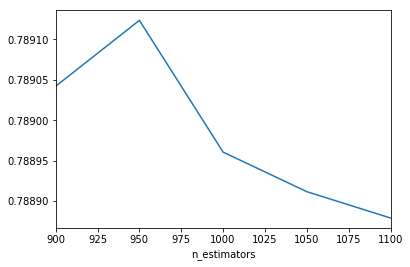

In [16]:
print(df5.groupby('n_estimators').mean()[['mean']])
df5.groupby('n_estimators').mean()['mean'].plot();

           mean
gamma          
0.0    0.792860
0.1    0.789632
0.2    0.791725
0.3    0.787774
0.4    0.784429
0.5    0.787480


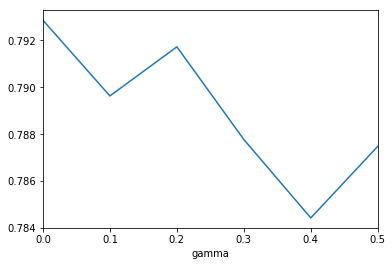

In [13]:
print(df5.groupby('gamma').mean()[['mean']])
df5.groupby('gamma').mean()['mean'].plot();

                      mean
min_child_weight          
0.0               0.789567
0.1               0.789619
0.2               0.786828
0.3               0.789919


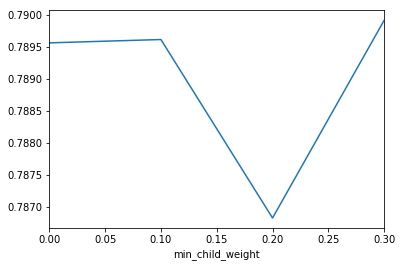

In [14]:
print(df5.groupby('min_child_weight').mean()[['mean']])
df5.groupby('min_child_weight').mean()['mean'].plot();

               mean
subsample          
0.9        0.789919
1.0        0.788048


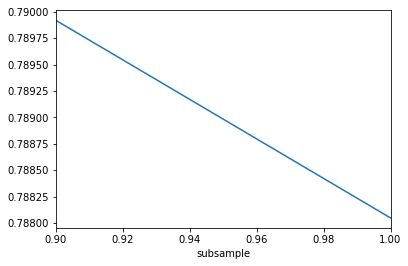

In [15]:
print(df5.groupby('subsample').mean()[['mean']])
df5.groupby('subsample').mean()['mean'].plot();

                mean
reg_lambda          
0.9         0.787643
1.0         0.790323


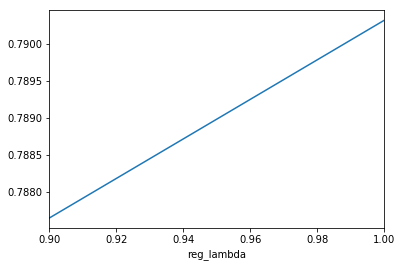

In [17]:
print(df5.groupby('reg_lambda').mean()[['mean']])
df5.groupby('reg_lambda').mean()['mean'].plot();

## Round 6 - Init

In [24]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [900, 925, 950, 975, 1000, 1025],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    
    # secondary
    'min_child_weight': [0, 0.5, 0.1],
    'subsample': [0.85, 0.9, 0.95],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0, 0.5, 0.1]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 1458 



In [25]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy'
                       )

bst_grid.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  1. ...,  1.  1.], n_folds=10, shuffle=True, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_lambda': [1], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], 'max_depth': [6], 'gamma': [0, 0.5, 0.1], 'reg_alpha': [0.5], 'min_child_weight': [0, 0.5, 0.1], 'subsample': [0.85, 0.9, 0.95], 'n_estimators': [900, 925, 950, 975, 1000, 1025]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [26]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df6 = get_grid_search_df(bst_grid, hp_list)

In [29]:
df6.head(25)

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0.0,0.15,6,0.816901,0.1,925,0.5,1,0.046791,0.90
1,0.0,0.15,6,0.816901,0.1,900,0.5,1,0.046791,0.90
2,0.1,0.01,6,0.816901,0.0,975,0.5,1,0.049129,0.85
3,0.1,0.01,6,0.816901,0.0,1000,0.5,1,0.049129,0.85
4,0.1,0.10,6,0.815336,0.0,1000,0.5,1,0.058089,0.85
5,0.0,0.01,6,0.815336,0.1,1025,0.5,1,0.051250,0.90
6,0.0,0.05,6,0.815336,0.5,1000,0.5,1,0.059784,0.85
7,0.0,0.05,6,0.815336,0.5,900,0.5,1,0.059784,0.85
8,0.0,0.05,6,0.815336,0.5,975,0.5,1,0.059784,0.85
9,0.0,0.15,6,0.815336,0.1,975,0.5,1,0.048698,0.90


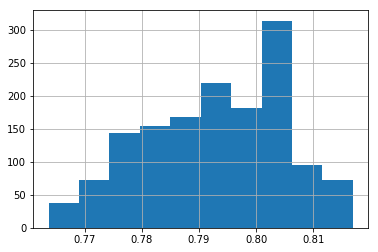

In [56]:
df6['mean'].hist();

           mean
gamma          
0.0    0.796480
0.1    0.793485
0.5    0.789376


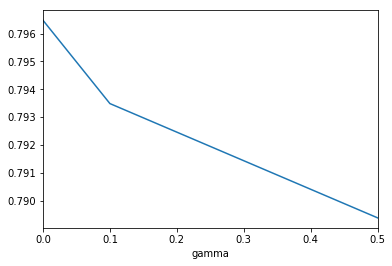

In [31]:
print(df6.groupby('gamma').mean()[['mean']])
df6.groupby('gamma').mean()['mean'].plot();

                   mean
learning_rate          
0.01           0.807908
0.05           0.802025
0.10           0.800383
0.15           0.797755
0.20           0.787950
0.25           0.788897
0.30           0.787303
0.35           0.783680
0.40           0.782125


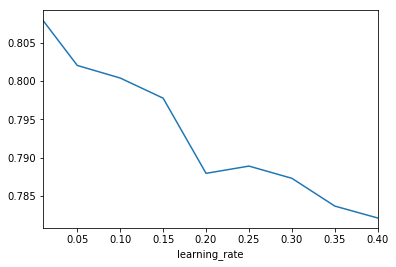

In [32]:
print(df6.groupby('learning_rate').mean()[['mean']])
df6.groupby('learning_rate').mean()['mean'].plot();

                  mean
n_estimators          
900           0.793195
925           0.793131
950           0.792976
975           0.793067
1000          0.793144
1025          0.793170


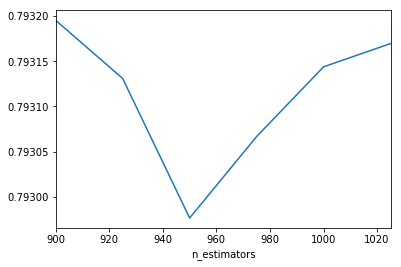

In [34]:
print(df6.groupby('n_estimators').mean()[['mean']])
df6.groupby('n_estimators').mean()['mean'].plot();

                      mean
min_child_weight          
0.0               0.793015
0.1               0.794074
0.5               0.792252


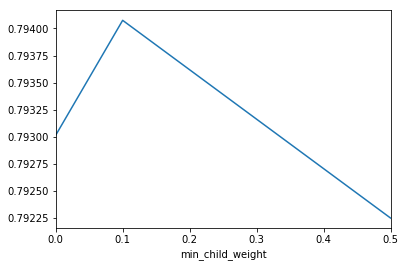

In [33]:
print(df6.groupby('min_child_weight').mean()[['mean']])
df6.groupby('min_child_weight').mean()['mean'].plot();

               mean
subsample          
0.85       0.790793
0.90       0.791428
0.95       0.797121


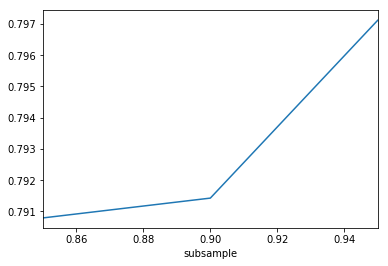

In [35]:
print(df6.groupby('subsample').mean()[['mean']])
df6.groupby('subsample').mean()['mean'].plot();

## Round 6 - High Performance Results

In [62]:
df6_hp = df6[df6['mean'] >= 0.8]

           mean
gamma          
0.0    0.807244
0.1    0.805874
0.5    0.804409


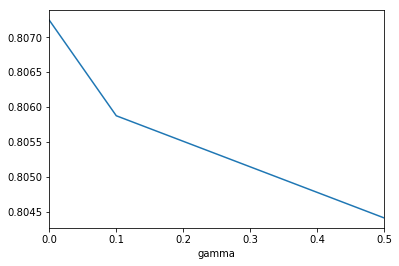

In [63]:
print(df6_hp.groupby('gamma').mean()[['mean']])
df6_hp.groupby('gamma').mean()['mean'].plot();

                   mean
learning_rate          
0.01           0.808294
0.05           0.805916
0.10           0.803937
0.15           0.804874
0.20           0.805702
0.25           0.805733
0.30           0.801252
0.40           0.801643


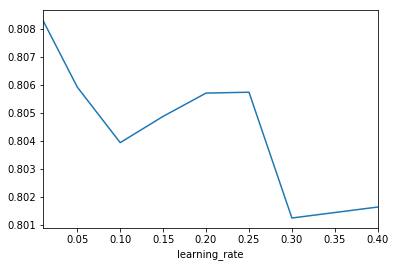

In [64]:
print(df6_hp.groupby('learning_rate').mean()[['mean']])
df6_hp.groupby('learning_rate').mean()['mean'].plot();

                  mean
n_estimators          
900           0.806198
925           0.805890
950           0.805908
975           0.805927
1000          0.806248
1025          0.806244


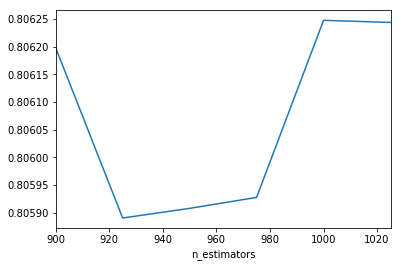

In [65]:
print(df6_hp.groupby('n_estimators').mean()[['mean']])
df6_hp.groupby('n_estimators').mean()['mean'].plot();

                      mean
min_child_weight          
0.0               0.806016
0.1               0.806205
0.5               0.805959


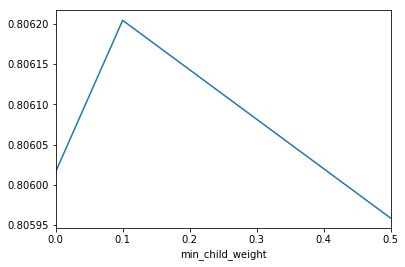

In [66]:
print(df6_hp.groupby('min_child_weight').mean()[['mean']])
df6_hp.groupby('min_child_weight').mean()['mean'].plot();

               mean
subsample          
0.85       0.806881
0.90       0.805295
0.95       0.806036


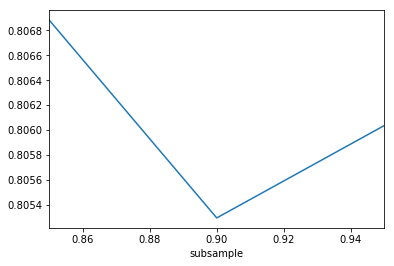

In [67]:
print(df6_hp.groupby('subsample').mean()[['mean']])
df6_hp.groupby('subsample').mean()['mean'].plot();

## Round 7 - Init

In [81]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [950, 970, 990, 1010, 1030, 1050,
                     1070, 1090, 1110, 1130, 1150, 1170,
                     1190, 1210, 1230, 1250, 1270, 1290
                    ],
    'learning_rate': [0.0010, 0.0025, 0.0050, 0.0075, 0.0100,
                      0.0150, 0.0200, 0.0300, 0.0400, 0.0500],
    
    # secondary
    'min_child_weight': [0.1],
    'subsample': [0.85],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 180 



In [2]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

## Round 7 - Results

In [84]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df7 = get_grid_search_df(bst_grid, hp_list)

In [89]:
df7.head(25)

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.020,6,0.807512,0.1,1130,0.5,1,0.046431,0.85
1,0,0.010,6,0.807512,0.1,1210,0.5,1,0.048959,0.85
2,0,0.010,6,0.807512,0.1,1190,0.5,1,0.048959,0.85
3,0,0.020,6,0.807512,0.1,1170,0.5,1,0.046431,0.85
4,0,0.020,6,0.807512,0.1,1190,0.5,1,0.046431,0.85
5,0,0.020,6,0.805947,0.1,1270,0.5,1,0.044890,0.85
6,0,0.020,6,0.805947,0.1,1110,0.5,1,0.044890,0.85
7,0,0.040,6,0.805947,0.1,1150,0.5,1,0.046809,0.85
8,0,0.015,6,0.805947,0.1,1210,0.5,1,0.045495,0.85
9,0,0.015,6,0.805947,0.1,1230,0.5,1,0.048123,0.85


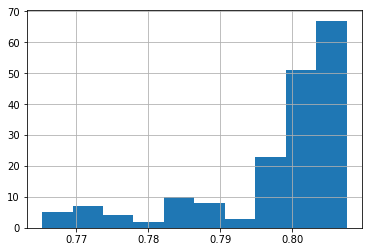

In [88]:
df7['mean'].hist();

                   mean
learning_rate          
0.0010         0.772214
0.0025         0.786211
0.0050         0.801861
0.0075         0.800296
0.0100         0.803425
0.0150         0.804556
0.0200         0.805773
0.0300         0.795079
0.0400         0.803339
0.0500         0.804990


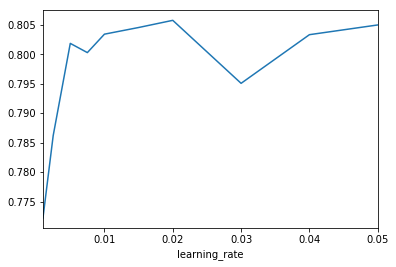

In [90]:
print(df7.groupby('learning_rate').mean()[['mean']])
df7.groupby('learning_rate').mean()['mean'].plot();

                  mean
n_estimators          
950           0.796714
970           0.796557
990           0.796557
1010          0.796244
1030          0.796244
1050          0.797027
1070          0.797496
1090          0.797183
1110          0.797966
1130          0.798122
1150          0.798435
1170          0.798592
1190          0.799218
1210          0.798592
1230          0.798905
1250          0.798748
1270          0.798748
1290          0.798592


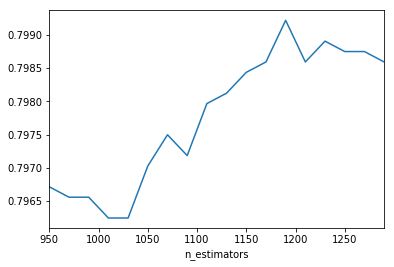

In [91]:
print(df7.groupby('n_estimators').mean()[['mean']])
df7.groupby('n_estimators').mean()['mean'].plot();

## Round 7 - High Performance Results

In [104]:
df7_hp = df7[(df7['mean'] > 0.8) & (df7['std'] < df7['std'].median())]

                   mean
learning_rate          
0.0050         0.803208
0.0075         0.801600
0.0100         0.803780
0.0150         0.804556
0.0200         0.805773
0.0400         0.803860


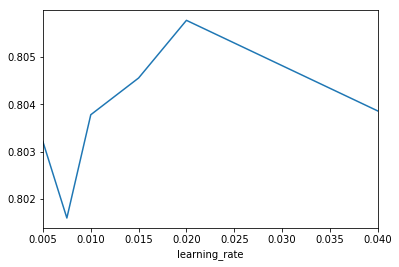

In [106]:
print(df7_hp.groupby('learning_rate').mean()[['mean']])
df7_hp.groupby('learning_rate').mean()['mean'].plot();

                  mean
n_estimators          
950           0.802817
970           0.803339
990           0.803339
1010          0.803599
1030          0.802817
1050          0.803339
1070          0.804903
1090          0.804382
1110          0.804382
1130          0.804773
1150          0.805321
1170          0.804382
1190          0.805321
1210          0.804382
1230          0.804382
1250          0.804382
1270          0.803599
1290          0.803208


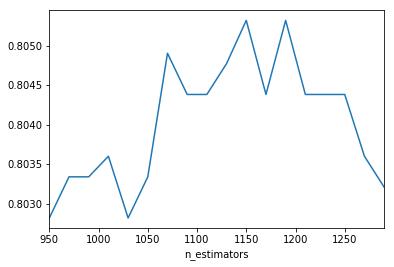

In [107]:
print(df7_hp.groupby('n_estimators').mean()[['mean']])
df7_hp.groupby('n_estimators').mean()['mean'].plot();

## Round 8 - Init

In [221]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [1070, 1080, 1110, 1020, 1130, 1040,
                     1150, 1060, 1170, 1080, 1190, 1200,
                     1210, 1220, 1230
                    ],
    'learning_rate': [0.0015, 0.0020, 0.0025, 0.0030],
    
    # secondary
    'min_child_weight': [0.05, 0.10, 0.15],
    'subsample': [0.8, 0.85, 0.9],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 540 



In [3]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [225]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df8 = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

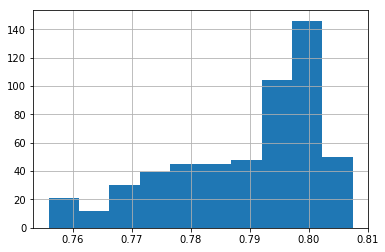

In [239]:
df8['mean'].hist();

In [242]:
df8_hp = df8[df8['mean'] >= 0.8]
df8_hp.head(25)

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.0030,6,0.807512,0.05,1220,0.5,1,0.051698,0.8
1,0,0.0030,6,0.807512,0.05,1210,0.5,1,0.052294,0.8
2,0,0.0030,6,0.805947,0.05,1190,0.5,1,0.052825,0.8
3,0,0.0030,6,0.805947,0.05,1170,0.5,1,0.054642,0.8
4,0,0.0030,6,0.805947,0.05,1230,0.5,1,0.052701,0.8
5,0,0.0030,6,0.804382,0.10,1170,0.5,1,0.053305,0.8
6,0,0.0030,6,0.804382,0.10,1130,0.5,1,0.052750,0.8
7,0,0.0030,6,0.804382,0.10,1110,0.5,1,0.054522,0.8
8,0,0.0030,6,0.804382,0.15,1130,0.5,1,0.048057,0.8
9,0,0.0030,6,0.804382,0.05,1190,0.5,1,0.055957,0.9


                  mean
n_estimators          
1020          0.802295
1040          0.802034
1060          0.801513
1070          0.802034
1080          0.801923
1110          0.803208
1130          0.802817
1150          0.802504
1170          0.803404
1190          0.802660
1200          0.802295
1210          0.802817
1220          0.802504
1230          0.802469


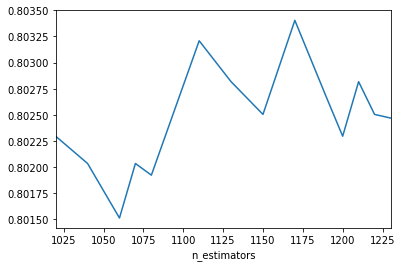

In [241]:
print(df8_hp.groupby('n_estimators').mean()[['mean']])
df8_hp.groupby('n_estimators').mean()['mean'].plot();

                   mean
learning_rate          
0.0025         0.801699
0.0030         0.802654


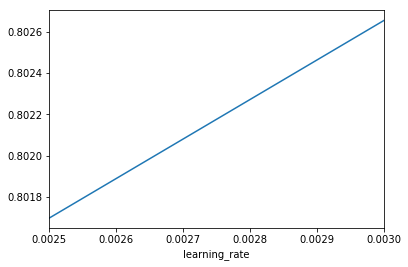

In [243]:
print(df8_hp.groupby('learning_rate').mean()[['mean']])
df8_hp.groupby('learning_rate').mean()['mean'].plot();

               mean
subsample          
0.80       0.802875
0.85       0.801513
0.90       0.801993


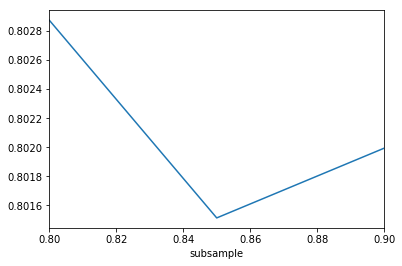

In [244]:
print(df8_hp.groupby('subsample').mean()[['mean']])
df8_hp.groupby('subsample').mean()['mean'].plot();

                      mean
min_child_weight          
0.05              0.802921
0.10              0.802034
0.15              0.802449


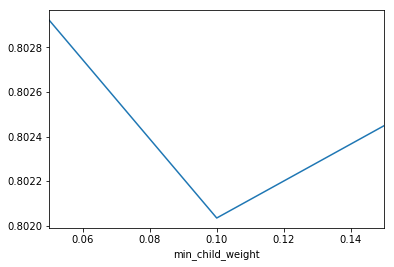

In [245]:
print(df8_hp.groupby('min_child_weight').mean()[['mean']])
df8_hp.groupby('min_child_weight').mean()['mean'].plot();

                  mean
n_estimators          
1020          0.798991
1040          0.800209
1060          0.799687
1070          0.799861
1080          0.799861
1110          0.799861
1130          0.800730
1150          0.800556
1170          0.801600
1190          0.801252
1200          0.800556
1210          0.801252
1220          0.801078
1230          0.800730


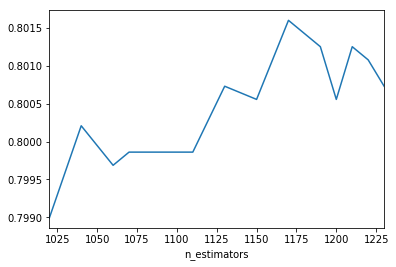

In [248]:
print(df8[df8.learning_rate == 0.0030].groupby('n_estimators').mean()[['mean']])
df8[df8.learning_rate == 0.0030].groupby('n_estimators').mean()['mean'].plot();

## Round 9 - Init

In [250]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250],
    'learning_rate': [0.0030],
    
    # secondary
    'min_child_weight': [0.05],
    'subsample': [0.8],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 11 



In [4]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [252]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df9 = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

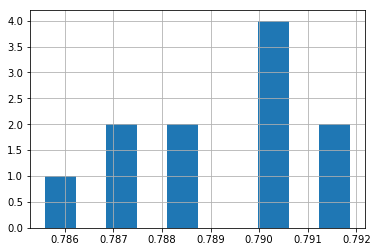

In [298]:
df9['mean'].hist();

In [254]:
df9.head()

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.003,6,0.791862,0.05,1220,0.5,1,0.048055,0.8
1,0,0.003,6,0.791862,0.05,1230,0.5,1,0.048055,0.8
2,0,0.003,6,0.790297,0.05,1200,0.5,1,0.047013,0.8
3,0,0.003,6,0.790297,0.05,1210,0.5,1,0.047013,0.8
4,0,0.003,6,0.790297,0.05,1240,0.5,1,0.046631,0.8


                  mean
n_estimators          
1150          0.785603
1160          0.788732
1170          0.787167
1180          0.787167
1190          0.788732
1200          0.790297
1210          0.790297
1220          0.791862
1230          0.791862
1240          0.790297
1250          0.790297


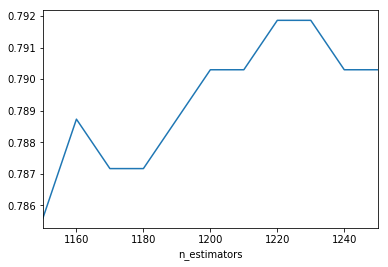

In [308]:
print(df9.groupby('n_estimators').mean()[['mean']])
df9.groupby('n_estimators').mean()['mean'].plot();

## Round 10 (alternate) - Init

In [291]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [900, 910, 920, 930],
    'learning_rate': [0.100, 0.125, 0.150],
    
    # secondary
    'min_child_weight': [0.1],
    'subsample': [0.85, 0.90],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 24 



In [5]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [293]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

df10 = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

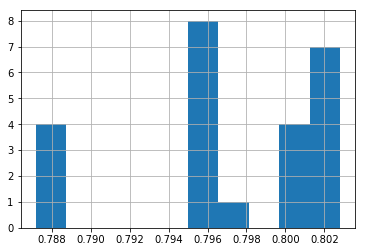

In [296]:
df10['mean'].hist();

In [299]:
df10

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.150,6,0.802817,0.1,900,0.5,1,0.033426,0.85
1,0,0.150,6,0.802817,0.1,930,0.5,1,0.033426,0.85
2,0,0.150,6,0.802817,0.1,920,0.5,1,0.033426,0.85
3,0,0.150,6,0.802817,0.1,910,0.5,1,0.033426,0.85
4,0,0.125,6,0.801252,0.1,920,0.5,1,0.039247,0.85
5,0,0.125,6,0.801252,0.1,910,0.5,1,0.039247,0.85
6,0,0.125,6,0.801252,0.1,930,0.5,1,0.039247,0.85
7,0,0.100,6,0.799687,0.1,910,0.5,1,0.049987,0.90
8,0,0.100,6,0.799687,0.1,920,0.5,1,0.049987,0.90
9,0,0.100,6,0.799687,0.1,930,0.5,1,0.049987,0.90


## FINAL BINARY MODEL

In [300]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950],
    'learning_rate': [0.15],
    
    # secondary
    'min_child_weight': [0.1],
    'subsample': [0.85],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 11 



In [6]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [302]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

dff = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

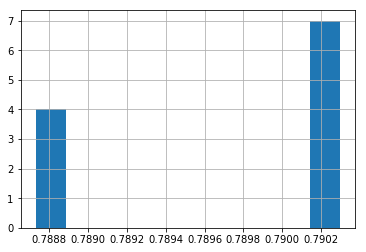

In [306]:
dff['mean'].hist();

In [307]:
dff.head()

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.15,6,0.790297,0.1,850,0.5,1,0.055833,0.85
1,0,0.15,6,0.790297,0.1,880,0.5,1,0.057196,0.85
2,0,0.15,6,0.790297,0.1,900,0.5,1,0.057196,0.85
3,0,0.15,6,0.790297,0.1,910,0.5,1,0.057196,0.85
4,0,0.15,6,0.790297,0.1,920,0.5,1,0.057196,0.85


## FINAL BINARY MODEL -- VERSION 2 -_-

In [310]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [1210, 1215, 1220, 1225, 1230, 1235, 1240],
    'learning_rate': [0.003],
    
    # secondary
    'min_child_weight': [0.05],
    'subsample': [0.8],
    'reg_alpha': [0.5],
    'reg_lambda': [1],
    'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 7 



In [7]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [312]:
hp_list = ['learning_rate',
           'max_depth',
           'n_estimators',
           'min_child_weight',
           'subsample',
           'reg_alpha',
           'reg_lambda',
           'gamma'
          ]

dfF = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

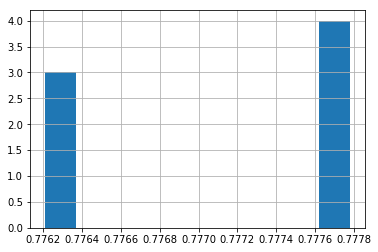

In [316]:
dfF['mean'].hist();

In [317]:
dfF

,gamma,learning_rate,max_depth,mean,min_child_weight,n_estimators,reg_alpha,reg_lambda,std,subsample
0,0,0.003,6,0.777778,0.05,1210,0.5,1,0.048588,0.8
1,0,0.003,6,0.777778,0.05,1215,0.5,1,0.048588,0.8
2,0,0.003,6,0.777778,0.05,1220,0.5,1,0.048588,0.8
3,0,0.003,6,0.777778,0.05,1240,0.5,1,0.050004,0.8
4,0,0.003,6,0.776213,0.05,1225,0.5,1,0.048704,0.8
5,0,0.003,6,0.776213,0.05,1230,0.5,1,0.048704,0.8
6,0,0.003,6,0.776213,0.05,1235,0.5,1,0.048704,0.8


# MULTICLASS CLASSIFICATION

In [2]:
# read in training data
df = pd.read_csv('train_recent.csv')

# clean import
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)

In [10]:
# pre-process data
adf, dat, dates = get_lstm_matrix(df,
                                  target_col = 'polo_btceth_close',
                                  periods_ahead = 4,
                                  drop_target = True,
                                  rate_of_change = True
                                 )

In [11]:
adf['polo_btceth_close_target'] = adf.polo_btceth_close_target.apply(lambda x: classify_target(x, 4, 0.03))

In [12]:
# set X and y
X = adf.ix[:,:-1].as_matrix()
y = adf.ix[:,-1].as_matrix()

In [41]:
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)

## Round 1 - Init

In [47]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [1, 2, 4, 6, 8, 10, 12],
    'n_estimators': [10, 25, 50, 100, 250, 500, 1000, 1500],
    #'learning_rate': [0.1, 0.25, 0.5, 1],
    
    # secondary
    #'min_child_weight': [0.1, 0.25, 0.5, 1],
    #'subsample': [0.90],
    #'reg_alpha': [0.5],
    #'reg_lambda': [1],
    #'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'multi:softmax',
    'silent': 0,
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 56 



In [8]:
# init the clf
_mod = XGBClassifier(**params_fixed)

# set the number of classes
xgb_param = _mod.get_xgb_params()
xgb_param['num_class'] = 4

# run grid search
bst_grid = GridSearchCV(estimator = _mod,
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

# fit the grid search
bst_grid.fit(X, label_encoded_y)

## Round 1 - Results

In [49]:
hp_list = ['max_depth',
           'n_estimators'
          ]

df11 = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

print("Best: %f using %s" % (bst_grid.best_score_, bst_grid.best_params_))

Best: 0.607199 using {'max_depth': 6, 'n_estimators': 500}


In [55]:
df11.head(10)

,max_depth,mean,n_estimators,std
0,6,0.607199,500,0.045010
1,6,0.604069,1000,0.056758
2,6,0.600939,1500,0.054400
3,6,0.597809,250,0.048034
4,12,0.593114,250,0.062171
5,12,0.593114,1500,0.073222
6,10,0.591549,1500,0.062406
7,12,0.591549,1000,0.065006
8,6,0.589984,100,0.060399
9,8,0.589984,500,0.049175


               mean
max_depth          
1          0.475939
2          0.523279
4          0.561424
6          0.588224
8          0.578443
10         0.575704
12         0.575117


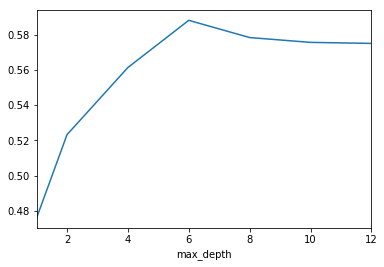

In [52]:
print(df11.groupby('max_depth').mean()[['mean']])
df11.groupby('max_depth').mean()['mean'].plot();

                  mean
n_estimators          
10            0.508384
25            0.530516
50            0.541247
100           0.552202
250           0.568746
500           0.574335
1000          0.577912
1500          0.578806


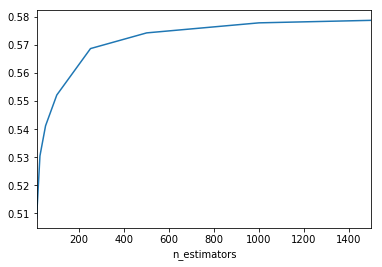

In [53]:
print(df11.groupby('n_estimators').mean()[['mean']])
df11.groupby('n_estimators').mean()['mean'].plot();

## Round 2 - Init

In [58]:
# set cross val object
cv = StratifiedKFold(y, n_folds = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [6],
    'n_estimators': [1000],
    'learning_rate': [0.01, 0.1, 0.25, 0.5, 1],
    
    # secondary
    'min_child_weight': [0, 0.1, 0.25, 0.5, 1],
    #'subsample': [0.90],
    #'reg_alpha': [0.5],
    #'reg_lambda': [1],
    #'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'multi:softmax',
    'silent': 0,
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 25 



In [9]:
# init the clf
_mod = XGBClassifier(**params_fixed)

# set the number of classes
xgb_param = _mod.get_xgb_params()
xgb_param['num_class'] = 4

# run grid search
bst_grid = GridSearchCV(estimator = _mod,
                        param_grid = params_grid,
                        cv = cv,
                        scoring = 'accuracy',
                        verbose = 2
                       )

# fit the grid search
bst_grid.fit(X, label_encoded_y)

In [63]:
hp_list = ['max_depth',
           'n_estimators',
           'learning_rate',
           'min_child_weight'
          ]

df11 = get_grid_search_df(bst_grid, hp_list, parse_mean = False)

print("Best: %f using %s" % (bst_grid.best_score_, bst_grid.best_params_))

Best: 0.600939 using {'max_depth': 6, 'min_child_weight': 0, 'learning_rate': 0.25, 'n_estimators': 1000}


In [64]:
df11.head(10)

,learning_rate,max_depth,mean,min_child_weight,n_estimators,std
0,0.25,6,0.600939,0.00,1000,0.042298
1,0.50,6,0.597809,0.50,1000,0.061439
2,0.50,6,0.597809,0.25,1000,0.045993
3,0.25,6,0.594679,0.50,1000,0.056625
4,1.00,6,0.594679,0.10,1000,0.057567
5,0.10,6,0.594679,0.00,1000,0.036875
6,0.50,6,0.594679,0.10,1000,0.057205
7,1.00,6,0.591549,0.25,1000,0.065938
8,0.25,6,0.591549,1.00,1000,0.057087
9,1.00,6,0.589984,0.00,1000,0.056289


                   mean
learning_rate          
0.01           0.577778
0.10           0.584977
0.25           0.592801
0.50           0.591236
1.00           0.583725


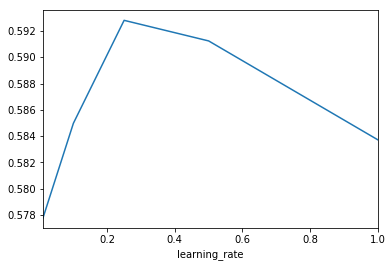

In [65]:
print(df11.groupby('learning_rate').mean()[['mean']])
df11.groupby('learning_rate').mean()['mean'].plot();

                      mean
min_child_weight          
0.00              0.591549
0.10              0.588419
0.25              0.588106
0.50              0.583412
1.00              0.579030


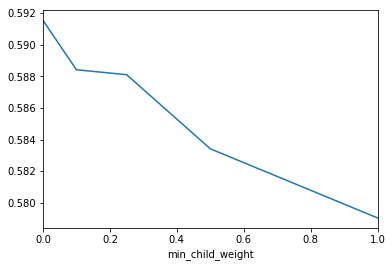

In [66]:
print(df11.groupby('min_child_weight').mean()[['mean']])
df11.groupby('min_child_weight').mean()['mean'].plot();

# REGRESSION

In [110]:
# read in training data
df = pd.read_csv('train_recent.csv')

# clean import
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)

In [119]:
# pre-process data
adf, dat, dates = get_lstm_matrix(df,
                                  target_col = 'polo_btceth_close',
                                  periods_ahead = 4,
                                  drop_target = True,
                                  rate_of_change = True
                                 )

# set X and y
X = adf.ix[:,:-1].as_matrix()
y = adf.ix[:,-1].as_matrix()

## Round 1

In [165]:
# set cross val object
cv = KFold(n_splits = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    #'learning_rate': [0.0015, 0.0020, 0.0025, 0.0030],
    
    # secondary
    #'min_child_weight': [0.1, 0.5, 1, 2, 4, 6, 8, 10, 12],
    #'subsample': [0.8, 0.85, 0.9],
    #'reg_alpha': [0.5],
    #'reg_lambda': [1],
    #'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'reg:linear',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 60 



In [10]:
bst_grid = GridSearchCV(estimator = XGBRegressor(**params_fixed),
                        param_grid = params_grid,
                        #cv = cv,
                        #scoring = 'neg_mean_squared_error',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [167]:
hp_list = ['max_depth',
           'n_estimators'
          ]

df8 = get_grid_search_df(bst_grid, hp_list, rmse = True)

In [168]:
df8.sort_values('mean').head(25)

,max_depth,mean,n_estimators,std
59,1,0.586597,200,0.296516
58,2,0.657132,200,0.274402
57,5,0.704726,200,0.542758
56,5,0.706566,1200,0.545183
55,5,0.706566,1000,0.545183
54,5,0.706566,800,0.545183
53,5,0.706566,600,0.545184
52,5,0.706569,400,0.545188
51,4,0.742932,200,0.506778
50,4,0.752784,1000,0.515262


In [164]:
for train_index, test_index in cv.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions) ** 0.5)

0.0668442762924
0.0393530472862
0.0454799334996
0.0451011257091
0.0663762089661
0.0664295676853
0.061807305678
0.0573593435377
0.0486216433098
0.0581449054786


## Round 2

In [170]:
# set cross val object
cv = KFold(n_splits = 10, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [1, 2, 3, 4, 6, 8, 10],
    'n_estimators': [10, 25, 50, 100, 200],
    #'learning_rate': [0.0015, 0.0020, 0.0025, 0.0030],
    
    # secondary
    #'min_child_weight': [0.1, 0.5, 1, 2, 4, 6, 8, 10, 12],
    #'subsample': [0.8, 0.85, 0.9],
    #'reg_alpha': [0.5],
    #'reg_lambda': [1],
    #'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'reg:linear',
    'silent': 0
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 35 



In [11]:
bst_grid = GridSearchCV(estimator = XGBRegressor(**params_fixed),
                        param_grid = params_grid,
                        #cv = cv,
                        #scoring = 'neg_mean_squared_error',
                        verbose = 2
                       )

bst_grid.fit(X, y)

In [172]:
hp_list = ['max_depth',
           'n_estimators'
          ]

df8 = get_grid_search_df(bst_grid, hp_list, rmse = True)

In [175]:
df8.sort_values('mean').head()

,max_depth,mean,n_estimators,std
34,1,0.418698,50,0.194079
33,2,0.447207,50,0.175400
32,1,0.450437,100,0.193533
31,2,0.560817,100,0.233105
30,1,0.586597,200,0.296516
